# 4.2 DataLoaderの作成

- 本ファイルでは、OpenPosetなど姿勢推定で使用するDatasetとDataLoaderを作成します。MS COCOデータセットを対象とします。

In [1]:
!git clone https://github.com/HisakaKoji/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 475 (delta 17), reused 0 (delta 0), pack-reused 443
Receiving objects: 100% (475/475), 15.43 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [6]:
%cd /content/pytorch_advanced/4_pose_estimation/

/content/pytorch_advanced/4_pose_estimation


In [0]:
import os
import urllib.request
import zipfile
import tarfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [0]:
# MSCOCOの2014 Val images [41K/6GB]をダウンロード
# 6GBのダウンロードと解凍なので時間がかかります（10分弱）
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

In [0]:
# mask.tar.gzの解凍
save_path = os.path.join(data_dir, "mask.tar.gz") 

with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall(data_dir)

# 学習目標

1.	マスクデータについて理解する
2.	OpenPoseで使用するDatasetクラス、DataLoaderクラスを実装できるようになる
3.	OpenPoseの前処理およびデータオーギュメンテーションで、何をしているのか理解する


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します





In [0]:
# 必要なパッケージのimport
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 画像、マスク画像、アノテーションデータへのファイルパスリストを作成

In [0]:
def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータ、マスクデータへのファイルパスリストを作成する。
    """

    # アノテーションのJSONファイルを読み込む
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # indexを格納
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 画像ファイルパスを格納
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [26]:
# 動作確認（実行には10秒ほど時間がかかります）
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]


{'annolist_index': 18.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'bbox_other': [[112.24, 245.32, 127.0, 110.76],
  [34.67, 208.02, 91.24, 152.36]],
 'dataset': 'COCO_val',
 'image_id': 488.0,
 'img_height': 406.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [127.0, 311.0, 1.0],
   [170.0, 307.0, 1.0],
   [180.0, 310.0, 1.0],
   [140.0, 341.0, 1.0],
   [148.0, 346.0, 1.0]],
  [[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [106.0, 227.0, 1.0],
   [92.0, 232.0, 1.0],
   [101.0, 232.0, 1.0],
   [0.0, 0.0, 2.0],
   [97.0, 257.0, 1.0],
   [0.0, 0.0, 2.0],
   [94.0, 282.0, 1.0],
   [55.0, 270.0, 1.0],
   [65.0, 271.0, 1.0

# マスクデータの働きを確認

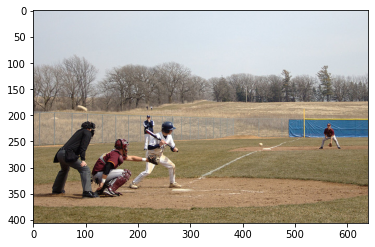

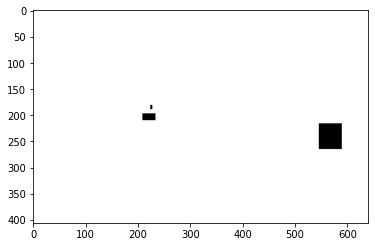

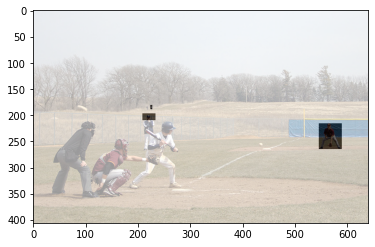

In [27]:
index = 24

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 画像の前処理作成

In [0]:
# データ処理のクラスとデータオーギュメンテーションのクラスをimportする
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor


class DataTransform():
    """
    画像とマスク、アノテーションの前処理クラス。
    学習時と推論時で異なる動作をする。
    学習時はデータオーギュメンテーションする。
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSONからアノテーションを辞書に格納
                add_neck(),  # アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加
                aug_scale(),  # 拡大縮小
                aug_rotate(),  # 回転
                aug_croppad(),  # 切り出し
                aug_flip(),  # 左右反転
                remove_illegal_joint(),  # 画像からはみ出たアノテーションを除去
                # Normalize_Tensor()  # 色情報の標準化とテンソル化
                no_Normalize_Tensor()  # 本節のみ、色情報の標準化をなくす
            ]),
            'val': Compose([
                # 本書では検証は省略
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss


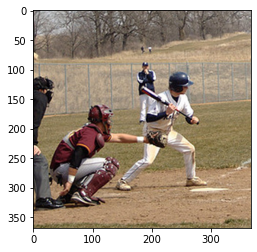

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


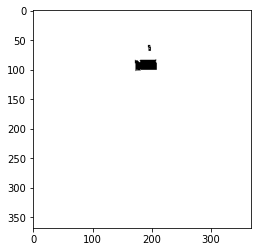

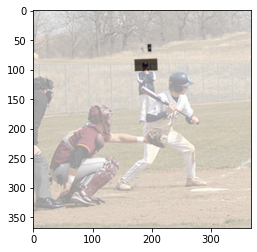

In [29]:
# 動作確認
# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 画像表示
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# マスク表示
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 合成 RGBにそろえてから
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 訓練データの正解情報として使うアノテーションデータの作成

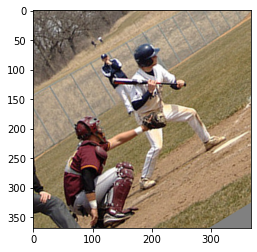

In [30]:
from utils.dataloader import get_ground_truth

# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPoseのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 画像表示
plt.imshow(img)
plt.show()

In [31]:
# 左肘のheatmapを確認

# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

In [32]:
# 左手首
heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

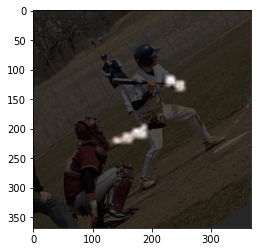

In [33]:
# 左肘と左手首へのPAFを確認
paf = pafs[:, :, 24]  # 24は左肘と左手首をつなぐ

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


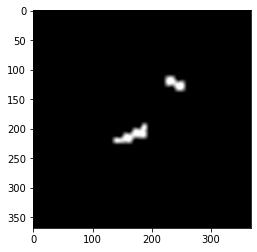

In [34]:
# PAFのみを表示
paf = pafs[:, :, 24]  # 24は左肘と左手首をつなぐ
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)


# Datasetの作成

In [0]:
from utils.dataloader import get_ground_truth


class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCOのCocokeypointsのDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス

    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーション、マスクを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. マスクとアノテーション読み込み
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 画像前処理
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 正解アノテーションデータの取得
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. マスクデータはRGBが(1,1,1)か(0,0,0)なので、次元を落とす
        # マスクデータはマスクされている場所は値が0、それ以外は値が1です
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. チャネルが最後尾にあるので順番を変える
        # 例：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [36]:
# 動作確認
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())


# データの取り出し例
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


# DataLoaderの作成

In [37]:
# データローダーの作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["train"])  # イタレータに変換
item = next(batch_iterator)  # 1番目の要素を取り出す
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


In [0]:
# 必要なパッケージのimport
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

In [0]:

class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()

        # Featureモジュール
        self.model0 = OpenPose_Feature()

        # Stageモジュール
        # PAFs（Part Affinity Fields）側
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap側
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        """順伝搬の定義"""

        # Featureモジュール
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)  # PAFs側
        out1_2 = self.model1_2(out1)  # confidence heatmap側

        # CStage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)  # 次元1のチャネルで結合
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 損失の計算用に各Stageの結果を格納
        saved_for_loss = []
        saved_for_loss.append(out1_1)  # PAFs側
        saved_for_loss.append(out1_2)  # confidence heatmap側
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        # 最終的なPAFsのout6_1とconfidence heatmapのout6_2、そして
        # 損失計算用に各ステージでのPAFsとheatmapを格納したsaved_for_lossを出力
        # out6_1：torch.Size([minibatch, 38, 46, 46])
        # out6_2：torch.Size([minibatch, 19, 46, 46])
        # saved_for_loss:[out1_1, out_1_2, ・・・, out6_2]

        return (out6_1, out6_2), saved_for_loss

In [0]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19の最初10個の畳み込みを使用
        # 初めて実行する際は、モデルの重みパラメータをダウンロードするため、実行に時間がかかる
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[0:23]  # VGG19の最初の10個の畳み込み層まで

        # 残りは新たな畳み込み層を2つ用意
        model['block0'].add_module("23", torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return outputs

In [0]:
def make_OpenPose_block(block_name):
    """
    コンフィグレーション変数からOpenPoseのStageモジュールのblcokを作成
    nn.Moduleではなく、nn.Sequentialにする
    """

    # 1. コンフィグレーションの辞書変数blocksを作成し、ネットワークを生成させる
    # 最初に全パターンの辞書を用意し、引数block_nameのみを生成する
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # 引数block_nameのコンフィグレーション辞書を取り出す
    cfg_dict = blocks[block_name]

    # 2. コンフィグレーション内容をリスト変数layersに格納
    layers = []

    # 0番目から最後の層までを作成
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layersをSequentialにする
    # ただし、最後にReLUはいらないのでその手前までを使用する
    net = nn.Sequential(*layers[:-1])

    # 4. 初期化関数の設定し、畳み込み層を初期化する

    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net

In [42]:
# モデルの定義
net = OpenPoseNet()
net.train()

# ダミーデータの作成
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 計算
outputs = net(dummy_img)
print(outputs)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



((tensor([[[[-2.8415e-06,  1.3655e-06,  2.4367e-06,  ..., -2.3962e-06,
           -2.3975e-05,  5.0604e-07],
          [ 1.9945e-06, -1.6247e-05, -2.2247e-05,  ..., -6.2832e-05,
           -3.2879e-05, -7.8290e-06],
          [-1.1006e-05, -4.2710e-05, -4.9535e-05,  ..., -6.5870e-05,
           -6.5920e-05, -6.2038e-05],
          ...,
          [-9.3711e-05, -9.7897e-05, -7.5808e-05,  ..., -5.7675e-05,
           -4.8101e-05, -1.3141e-05],
          [-4.4685e-05, -1.7404e-05, -3.0018e-05,  ..., -2.5794e-05,
            7.2853e-06, -2.6303e-05],
          [-4.1427e-05, -3.3715e-05, -6.5294e-05,  ..., -2.6961e-05,
           -9.6616e-06, -1.0517e-05]],

         [[-2.1216e-05, -4.1802e-05, -5.7537e-05,  ..., -1.7556e-05,
           -1.3748e-05,  1.5331e-05],
          [-2.1987e-05, -3.1188e-05, -3.3847e-05,  ...,  5.1744e-06,
            3.4452e-05,  5.9408e-06],
          [-3.6236e-05, -6.0857e-05, -6.9892e-05,  ..., -1.7842e-05,
            6.9005e-06, -5.4163e-06],
          ...,
  

In [0]:
# 必要なパッケージのimport
import torch

In [44]:
from utils.openpose_net import OpenPoseNet
# モデルの用意
net = OpenPoseNet()
net.train()

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

In [46]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 9.0MB/s 


In [0]:
# 1. tensorboardXの保存クラスを呼び出します
from tensorboardX import SummaryWriter

# 2. フォルダ「tbX」に保存させるwriterを用意します
# フォルダ「tbX」はなければ自動で作成されます
writer = SummaryWriter("./tbX/")


# 3. ネットワークに流し込むダミーデータを作成します
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 4. OpenPoseのインスタンスnetに対して、ダミーデータである
# dummy_imgを流したときのgraphをwriterに保存させます
writer.add_graph(net, (dummy_img, ))
writer.close()


# 5. コマンドプロンプトを開き、フォルダ「tbX」がある
# フォルダ「4_pose_estimation」まで移動して、
# 以下のコマンドを実行します

# tensorboard --logdir="./tbX/"

# その後、http://localhost:6006
# にアクセスします

In [0]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:

# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [0]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset

# MS COCOのファイルパスリスト作成
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

# Dataset作成
# 本書ではデータ量の問題から、trainをval_listで作成している点に注意
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())

# 今回は簡易な学習とし検証データは作成しない
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader作成
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict = {"train": train_dataloader, "val": None}

In [0]:

from utils.openpose_net import OpenPoseNet
net = OpenPoseNet()

In [0]:
# 損失関数の設定
class OpenPoseLoss(nn.Module):
    """OpenPoseの損失関数のクラスです。"""

    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        損失関数の計算。

        Parameters
        ----------
        saved_for_loss : OpenPoseNetの出力(リスト)

        heatmap_target : [num_batch, 19, 46, 46]
            正解の部位のアノテーション情報

        heatmap_mask : [num_batch, 19, 46, 46]
            heatmap画像のmask

        paf_target : [num_batch, 38, 46, 46]
            正解のPAFのアノテーション情報

        paf_mask : [num_batch, 38, 46, 46]
            PAF画像のmask

        Returns
        -------
        loss : テンソル
            損失の値
        """

        total_loss = 0
        # ステージごとに計算します
        for j in range(6):

            # PAFsとheatmapsにおいて、マスクされている部分（paf_mask=0など）は無視させる
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2 * j + 1] * heat_mask
            gt2 = heatmap_target.float()*heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss


criterion = OpenPoseLoss()

In [0]:

optimizer = optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

In [0]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                optimizer.zero_grad()
                print('（train）')

            # 今回は検証はスキップ
            else:
                continue
                # net.eval()   # モデルを検証モードに
                # print('-------------')
                # print('（val）')

            # データローダーからminibatchずつ取り出すループ
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)は使わないので _ で代替
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    # else:
                        #epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/openpose_net_' +
               str(epoch+1) + '.pth')

In [55]:
# 学習・検証を実行する
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/2
-------------
（train）
イテレーション 10 || Loss: 0.0094 || 10iter: 64.6723 sec.
イテレーション 20 || Loss: 0.0082 || 10iter: 54.4587 sec.
イテレーション 30 || Loss: 0.0069 || 10iter: 51.2956 sec.
イテレーション 40 || Loss: 0.0058 || 10iter: 55.9679 sec.
イテレーション 50 || Loss: 0.0050 || 10iter: 55.3317 sec.
イテレーション 60 || Loss: 0.0042 || 10iter: 55.5904 sec.
イテレーション 70 || Loss: 0.0038 || 10iter: 58.0324 sec.
イテレーション 80 || Loss: 0.0031 || 10iter: 57.4150 sec.
イテレーション 90 || Loss: 0.0027 || 10iter: 58.2186 sec.
イテレーション 100 || Loss: 0.0026 || 10iter: 58.3703 sec.
イテレーション 110 || Loss: 0.0023 || 10iter: 57.9369 sec.
イテレーション 120 || Loss: 0.0020 || 10iter: 55.8294 sec.
イテレーション 130 || Loss: 0.0020 || 10iter: 56.4117 sec.
イテレーション 140 || Loss: 0.0019 || 10iter: 58.8185 sec.
イテレーション 150 || Loss: 0.0016 || 10iter: 55.8750 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0043 ||Epoch_VAL_Loss:0.0000
timer:  885.9465 sec.
-------------
Epoch 2/2
-------------
（train）
イテレーション 160 || Loss: 0.0017

In [0]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [57]:

from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本章のモデルでネットワークの層の名前が違うので、対応させてロードする
# モデルの定義
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を、本書で構築したモデルの
# パラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


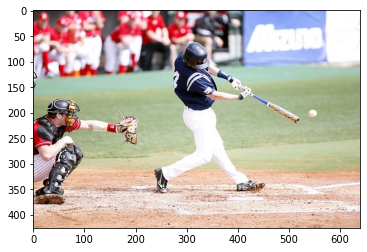

In [58]:
# 草野球の画像を読み込み、前処理します

test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,Rの順番

# BGRをRGBにして表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （高さ、幅、色）→（色、高さ、幅）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をTensorに
img = torch.from_numpy(img)

# ミニバッチ化：torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [0]:
# OpenPoseでheatmapsとPAFsを求めます
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルからNumPyに変化し、サイズを戻します
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

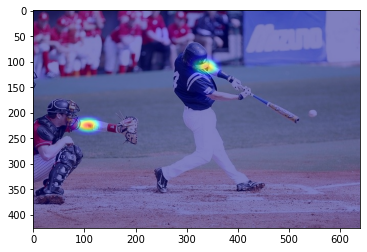

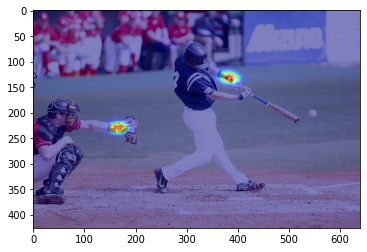

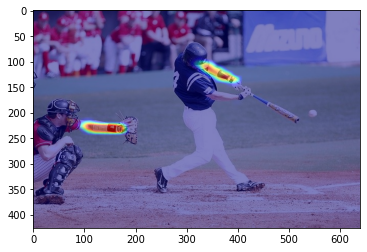

In [60]:
# 左肘と左手首のheatmap、そして左肘と左手首をつなぐPAFを可視化する
# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左手首
heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左肘と左手首をつなぐPAF
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [0]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

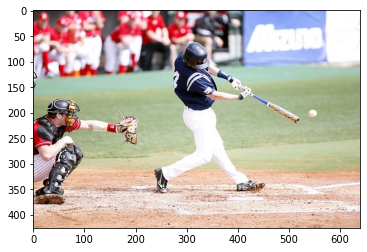

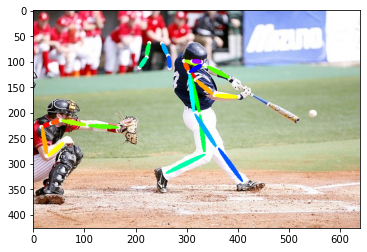

In [62]:
# 結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

以上